# Exective summary of Work Package 3

## Objectives

In this WP, you will work on a given training dataset. Your goal is to develop a fault detection model using the regression algorithms learnt in the class, in order to achieve best F1 score。

## Tasks

- Task 1: Develop a regression model to predict the reference value for motor temperature.
- Task 2: Develop a fault detection model using the regression model you developed in Task 1.

## Delierables

- A Jupyter notebook reporting the process and results of the above tasks


# Before starting, please:
- Fetch the most up-to-date version of the github repository.
- Create a new branch with your name, based on the "main" branch and switch to your own branch.
- Copy this notebook to the work space of your group, and rename it to TD_WP_3_Your name.ipynb
- After finishing this task, push your changes to the github repository of your group.

# Task 1: Predict normal behaviors through regression models

In this task, let us try to develop a best regression model to predict the normal behaviors of a given motor. In this exercise, we can use motor 6 as an example. You can easilily generate the approach to other models for the data challenge.

We can use all the dataset where motor 6 works normally as our dataset. Then, we can run a cross validation (based on sequence, not points) to test the performances of the developed model.

In this example, we mainly use the following performance metrics:
- max error: The max error between the predicted and the true values.
- Mean root squared error: The mean root squared error between the predicted and the true values.
- Out-of-boundary rate: The percentage that the residual error between the predicted and the true values is larger than a given threshold. Here, we set the thresold to be $3$ degree.

## Sub-task 1: Only use the features at the current moment.

[This notebook](demo_regression_mdl.ipynb) provides a basic demonstration of how to set up the experiment. Let us start by considering only using the features from the current moment. In the notebook, we show a baseline using a simple linear regression with all the features. Could you please try to improve the performance of the model?

A few possible directions:
- Feature selection?
- Smoothing?
- Removing sequence-to-sequence variablity? Adding features regarding time dynamics (see the TD for last lecture).
- Changing to other regression models? For this, you can try different regression models from [here](https://scikit-learn.org/stable/supervised_learning.html)

Put your code below.

In [1]:
from utility import read_all_test_data_from_path
import numpy as np
import pandas as pd


def pre_processing(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()


base_dictionary = '../../dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)

In [2]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt


# Function to design a Butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


# Function to apply the Butterworth low-pass filter
def lowpass_filter(data, cutoff_freq, sampling_freq, order=5):
    b, a = butter_lowpass(cutoff_freq, sampling_freq, order=order)
    filtered_data = filtfilt(b, a, data)
    return filtered_data


# Set parameters for the low-pass filter
cutoff_frequency = .5  # Adjust as needed
sampling_frequency = 10  # Assuming your data is evenly spaced in time


def customized_outlier_removal(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].ffill()
    df['position'] = lowpass_filter(df['position'], cutoff_frequency, sampling_frequency)
    # df['position'] = df['position'].rolling(window=10, min_periods=1).mean()
    df['position'] = df['position'].round()

    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    # df['temperature'] = df['temperature'].rolling(window=10, min_periods=1).mean()

    # Make sure that the difference between the current and previous temperature cannot be too large.
    # Define your threshold
    threshold = 10
    # Shift the 'temperature' column by one row to get the previous temperature
    prev_tmp = df['temperature'].shift(1)
    # Calculate the absolute difference between current and previous temperature
    temp_diff = np.abs(df['temperature'] - prev_tmp)
    # Set the temperature to NaN where the difference is larger than the threshold
    df.loc[temp_diff > threshold, 'temperature'] = np.nan
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 8000, np.nan)
    df['voltage'] = df['voltage'].ffill()
    # df['voltage'] = lowpass_filter(df['voltage'], cutoff_frequency, sampling_frequency)
    # df['voltage'] = df['voltage'].rolling(window=5, min_periods=1).mean()
    

from utility import read_all_csvs_one_test
import matplotlib.pyplot as plt
import pandas as pd
import os

# Get all the folders in the base_dictionary
path_list = os.listdir(base_dictionary)
# Only keep the folders, not the excel file.
path_list = path_list[:-1]

# Read the data.
df_data_smoothing = pd.DataFrame()
for tmp_path in path_list:
    path = base_dictionary + tmp_path
    # Read the data with the customized outlier removal function.
    tmp_df = read_all_csvs_one_test(path, tmp_path, customized_outlier_removal)
    df_data_smoothing = pd.concat([df_data_smoothing, tmp_df])
    df_data_smoothing = df_data_smoothing.reset_index(drop=True)

# Read the test conditions
df_test_conditions = pd.read_excel(base_dictionary+'Test conditions.xlsx')

# # Visulize the data
# for selected_sequence_idx in path_list:
#     filtered_df = df_data_smoothing[df_data_smoothing['test_condition'] == selected_sequence_idx]

#     print('{}: {}\n'.format(selected_sequence_idx, df_test_conditions[df_test_conditions['Test id'] == selected_sequence_idx]['Description']))

#     fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
#     for ax, col in zip(axes.flat, ['data_motor_1_position', 'data_motor_2_position', 'data_motor_3_position', 
#         'data_motor_1_temperature', 'data_motor_2_temperature', 'data_motor_3_temperature',
#         'data_motor_1_voltage', 'data_motor_2_voltage', 'data_motor_3_voltage']):
#         ax.plot(filtered_df['time'], filtered_df[col], marker='o', label=col)
#         ax.set_ylabel(col)

#     fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
#     for ax, col in zip(axes.flat, ['data_motor_4_position', 'data_motor_5_position', 'data_motor_6_position',
#         'data_motor_4_temperature', 'data_motor_5_temperature', 'data_motor_6_temperature',
#         'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage']):
#         ax.plot(filtered_df['time'], filtered_df[col], marker='o', label=col)
#         ax.set_ylabel(col)

#     plt.show()

In [3]:
normal_test_id = ['20240105_164214', 
    '20240105_165300', 
    '20240105_165972', 
    '20240320_152031', 
    '20240320_153841', 
    '20240320_155664', 
    '20240321_122650', 
    '20240325_135213', 
    '20240426_141190', 
    '20240426_141532', 
    '20240426_141602', 
    '20240426_141726', 
    '20240426_141938', 
    '20240426_141980', 
    '20240503_164435']
df_data = df_data[df_data['test_condition'].isin(normal_test_id)]
df_data_smoothing = df_data_smoothing[df_data_smoothing['test_condition'].isin(normal_test_id)]


In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge,Lasso
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC 


# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', LinearRegression())    # Step 2: Linear Regression
]

# Create the pipeline
mdl_linear_regreession = Pipeline(steps)

In [17]:
#Smoothing


df_data=df_data.rolling(window=20, min_periods=1).mean()


Model for motor 6:


c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 14.298214385333905
training performance, mean root square error is: 2.8007133910008393
training performance, residual error > 1: 51.21976829652445%

 New run:

testing performance, max error is: 6.4658923129141455
testing performance, mean root square error is: 1.2102924553022822
testing performance, residual error > 1: 16.98640342708139%


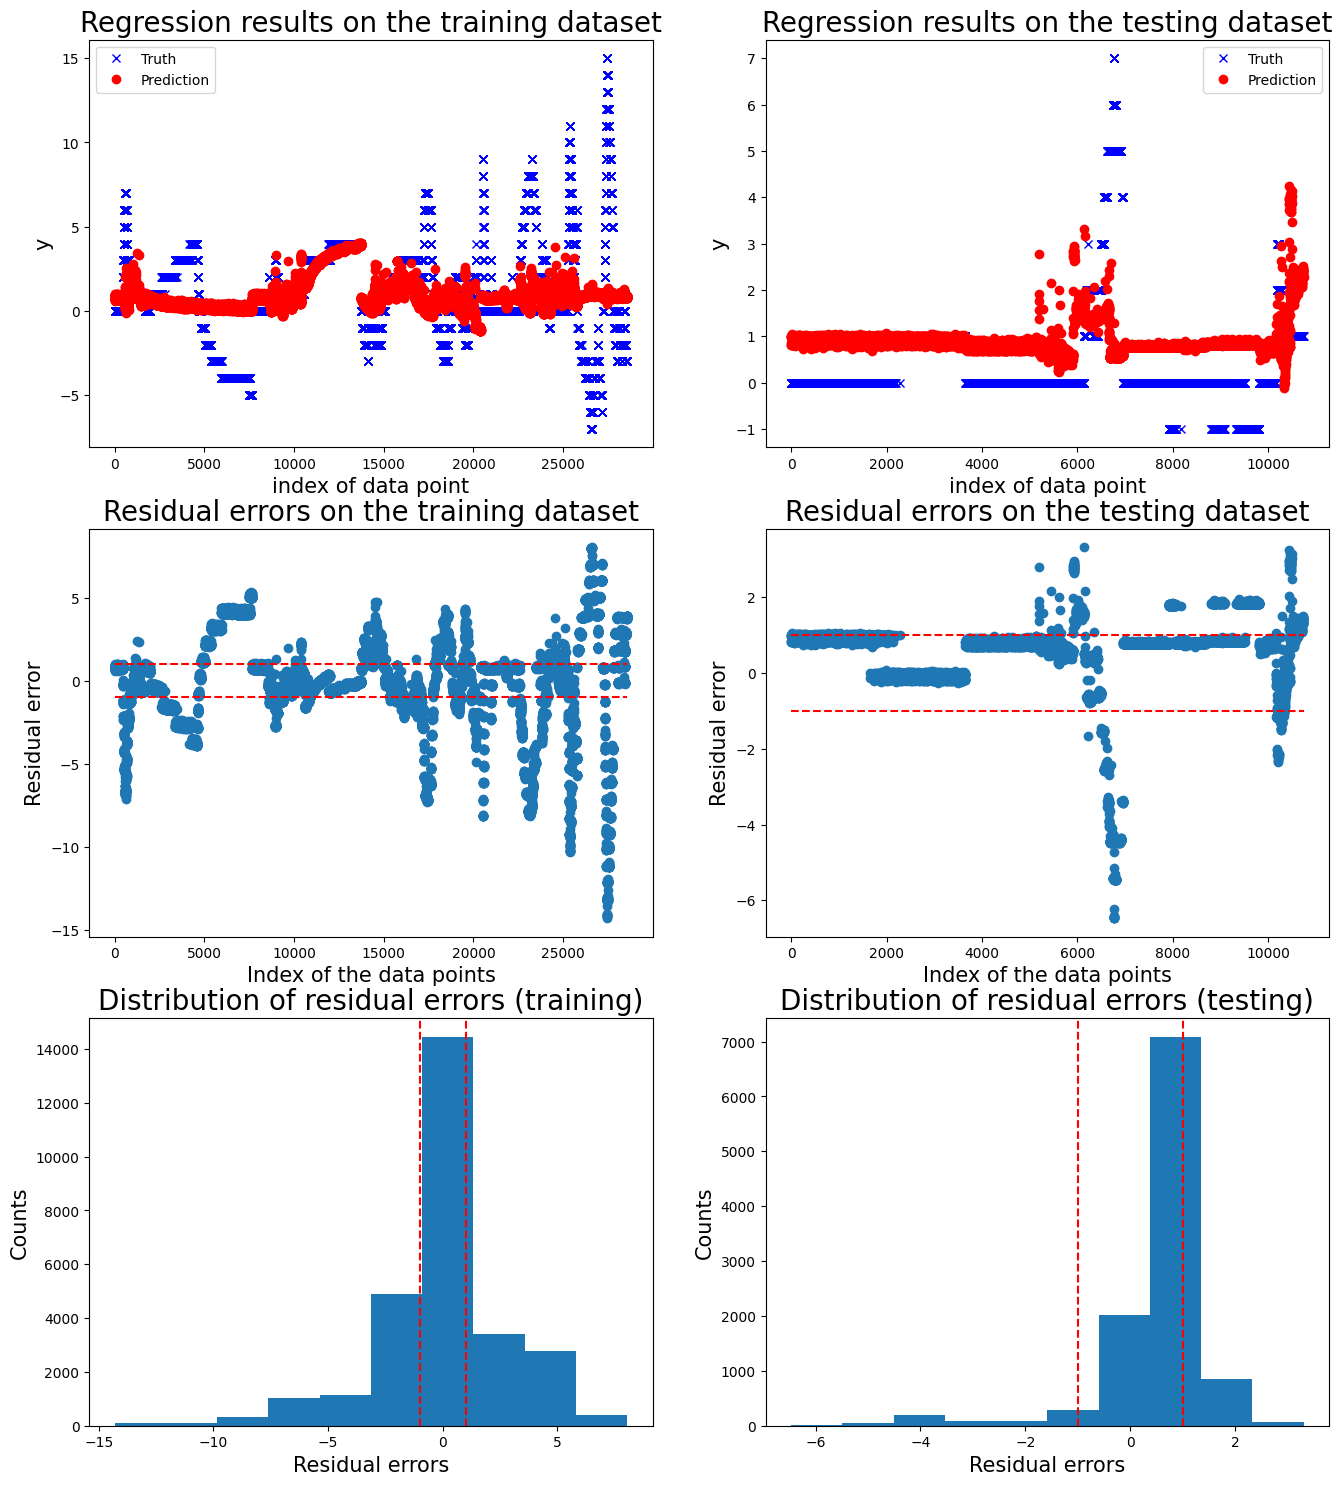

c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 14.904461132748608
training performance, mean root square error is: 2.3393253626049564
training performance, residual error > 1: 36.267978003384094%

 New run:

testing performance, max error is: 10.91825914729165
testing performance, mean root square error is: 3.912235007177224
testing performance, residual error > 1: 65.87243222042457%


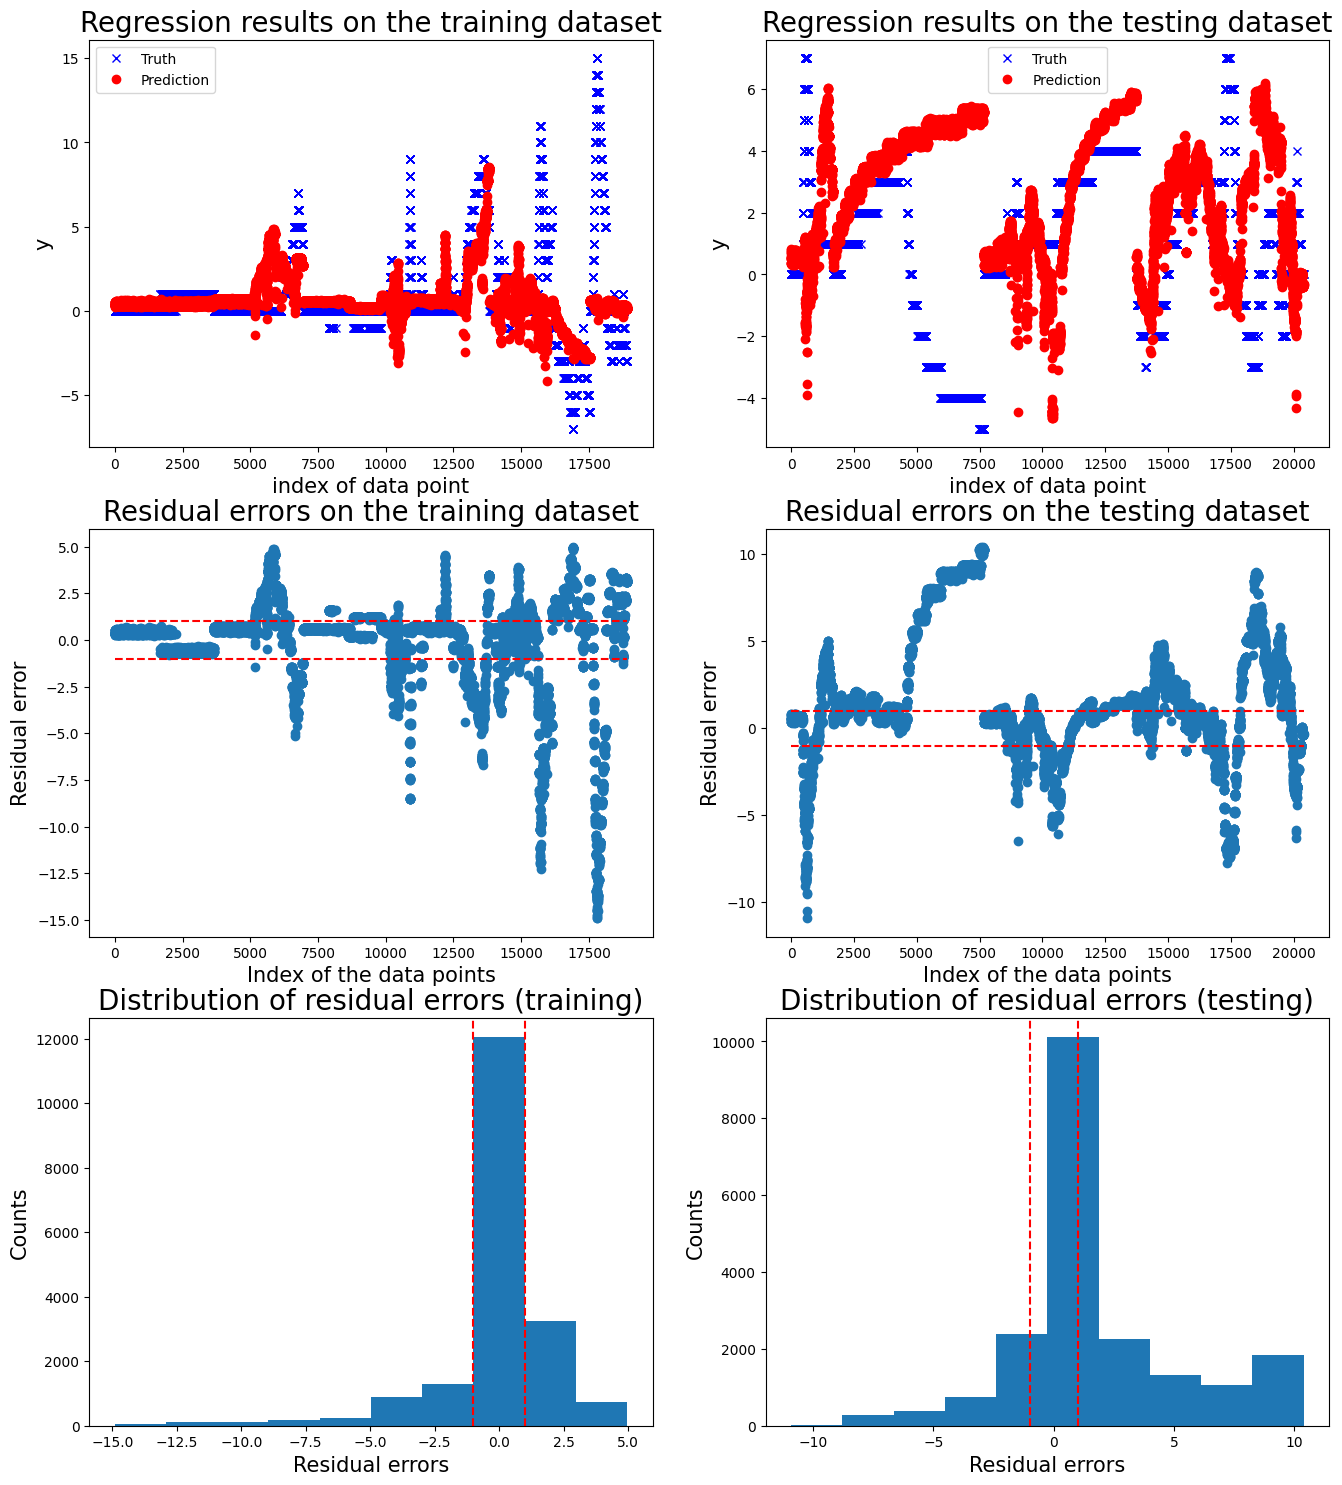

c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 14.502074119667576
training performance, mean root square error is: 2.364993695983847
training performance, residual error > 1: 42.180121273088%

 New run:

testing performance, max error is: 8.714871700374013
testing performance, mean root square error is: 3.434792669588451
testing performance, residual error > 1: 33.475298126064736%


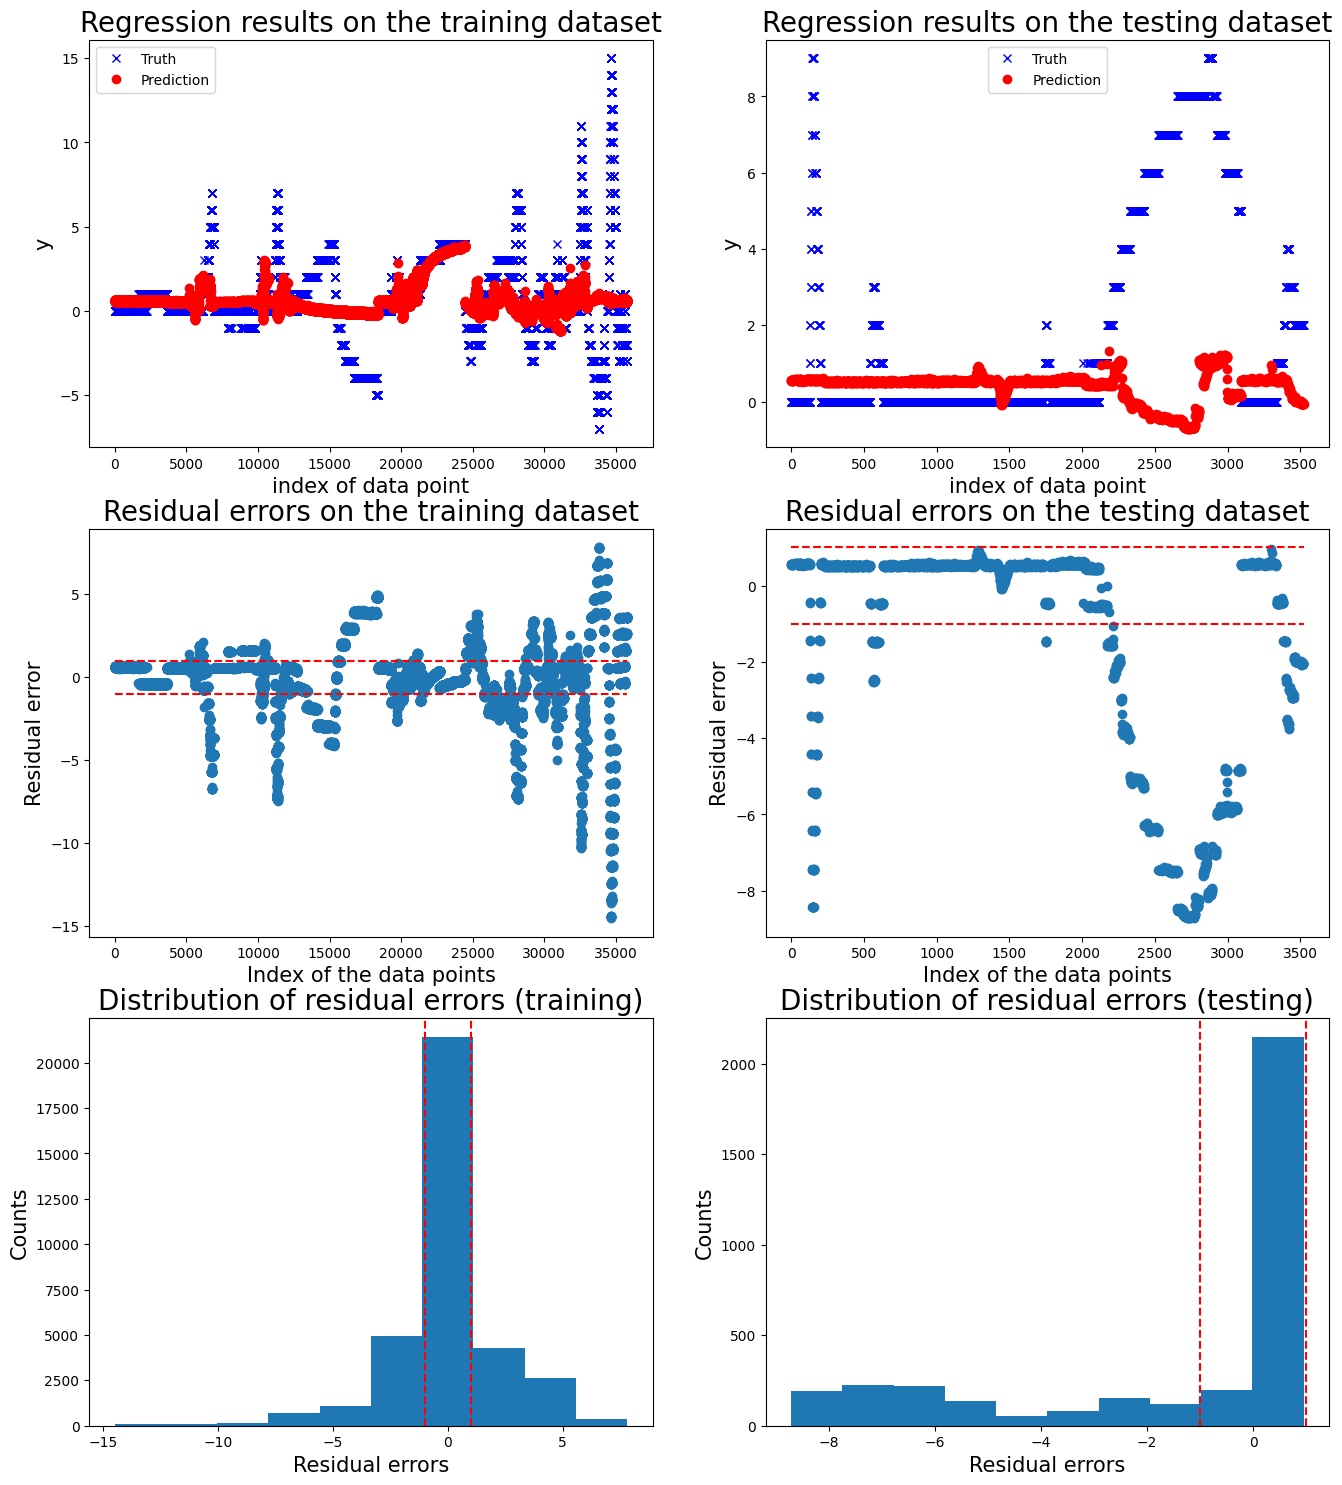

c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 14.463075993542542
training performance, mean root square error is: 2.4820527894388413
training performance, residual error > 1: 41.55413286332651%

 New run:

testing performance, max error is: 3.172869973692392
testing performance, mean root square error is: 0.8793485936330447
testing performance, residual error > 1: 26.373626373626376%


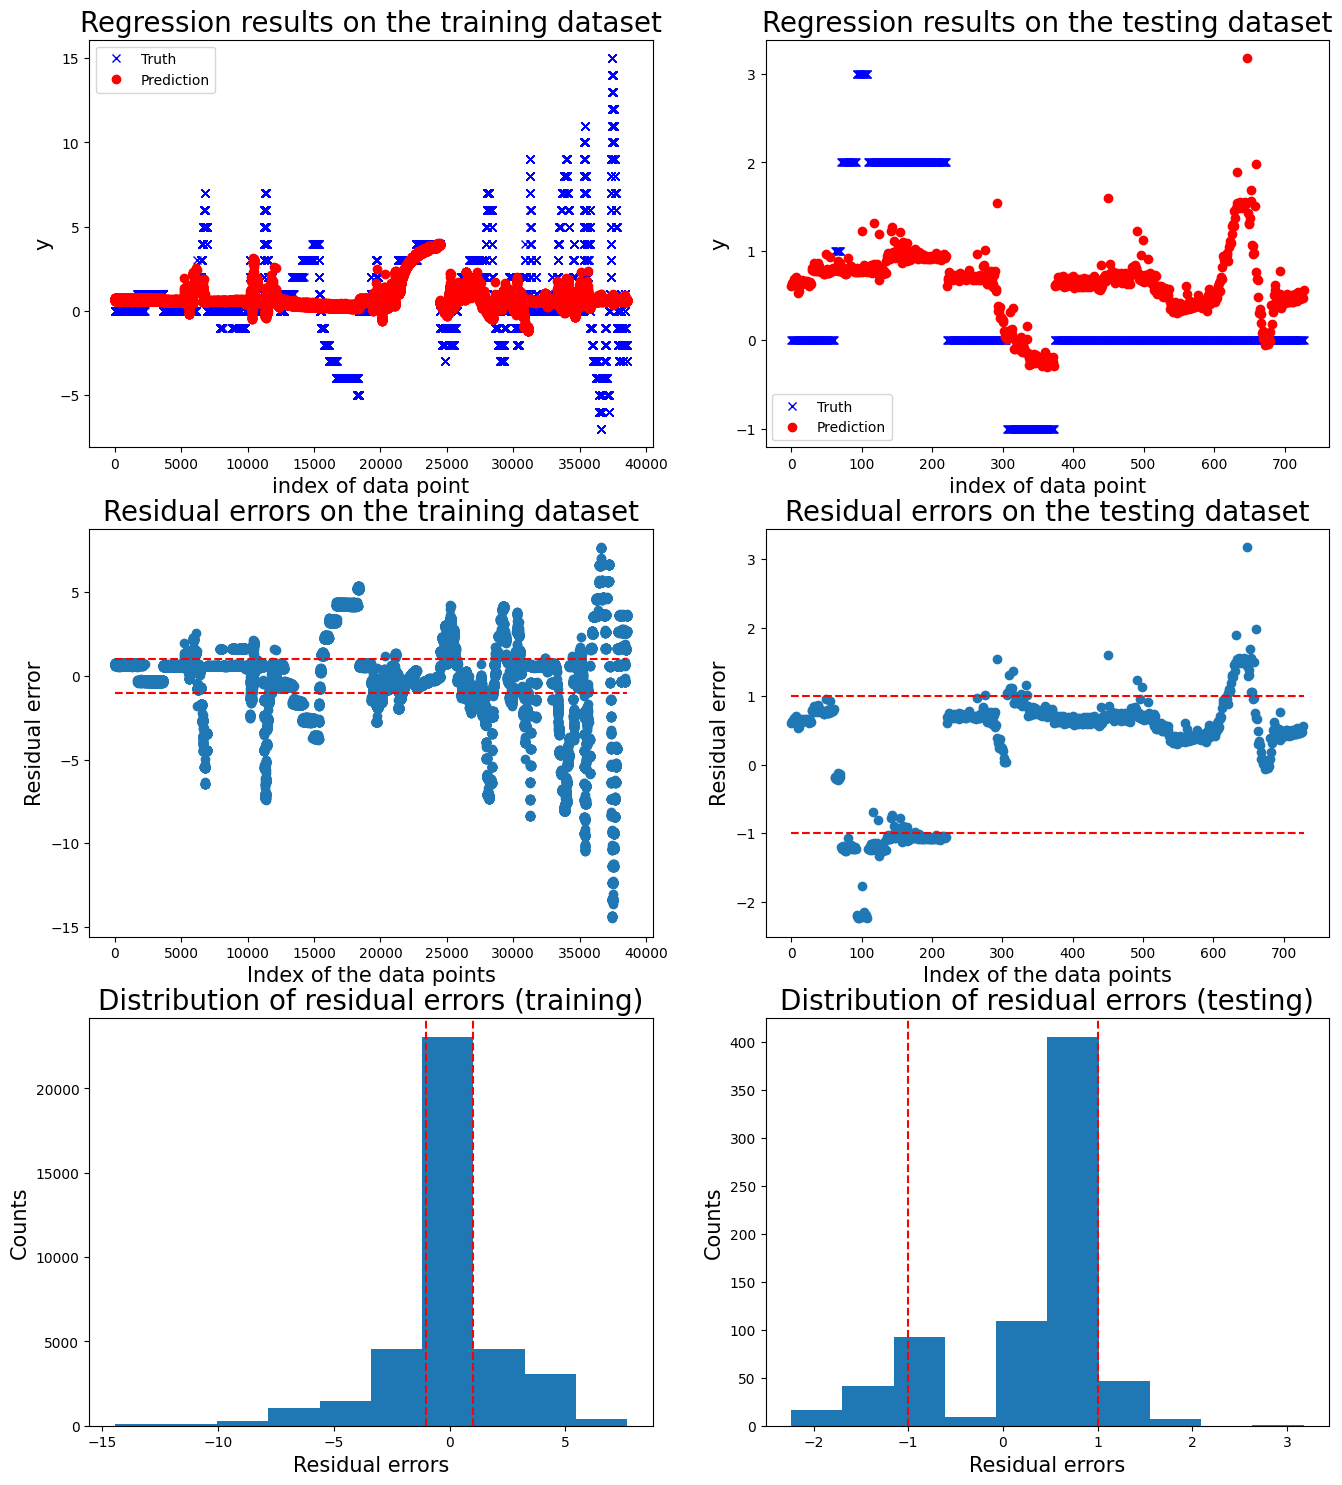

c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 8.298230991547435
training performance, mean root square error is: 2.0441019690166837
training performance, residual error > 1: 37.53850501624982%

 New run:

testing performance, max error is: 14.296531540498945
testing performance, mean root square error is: 4.872451785037202
testing performance, residual error > 1: 78.9500509683996%


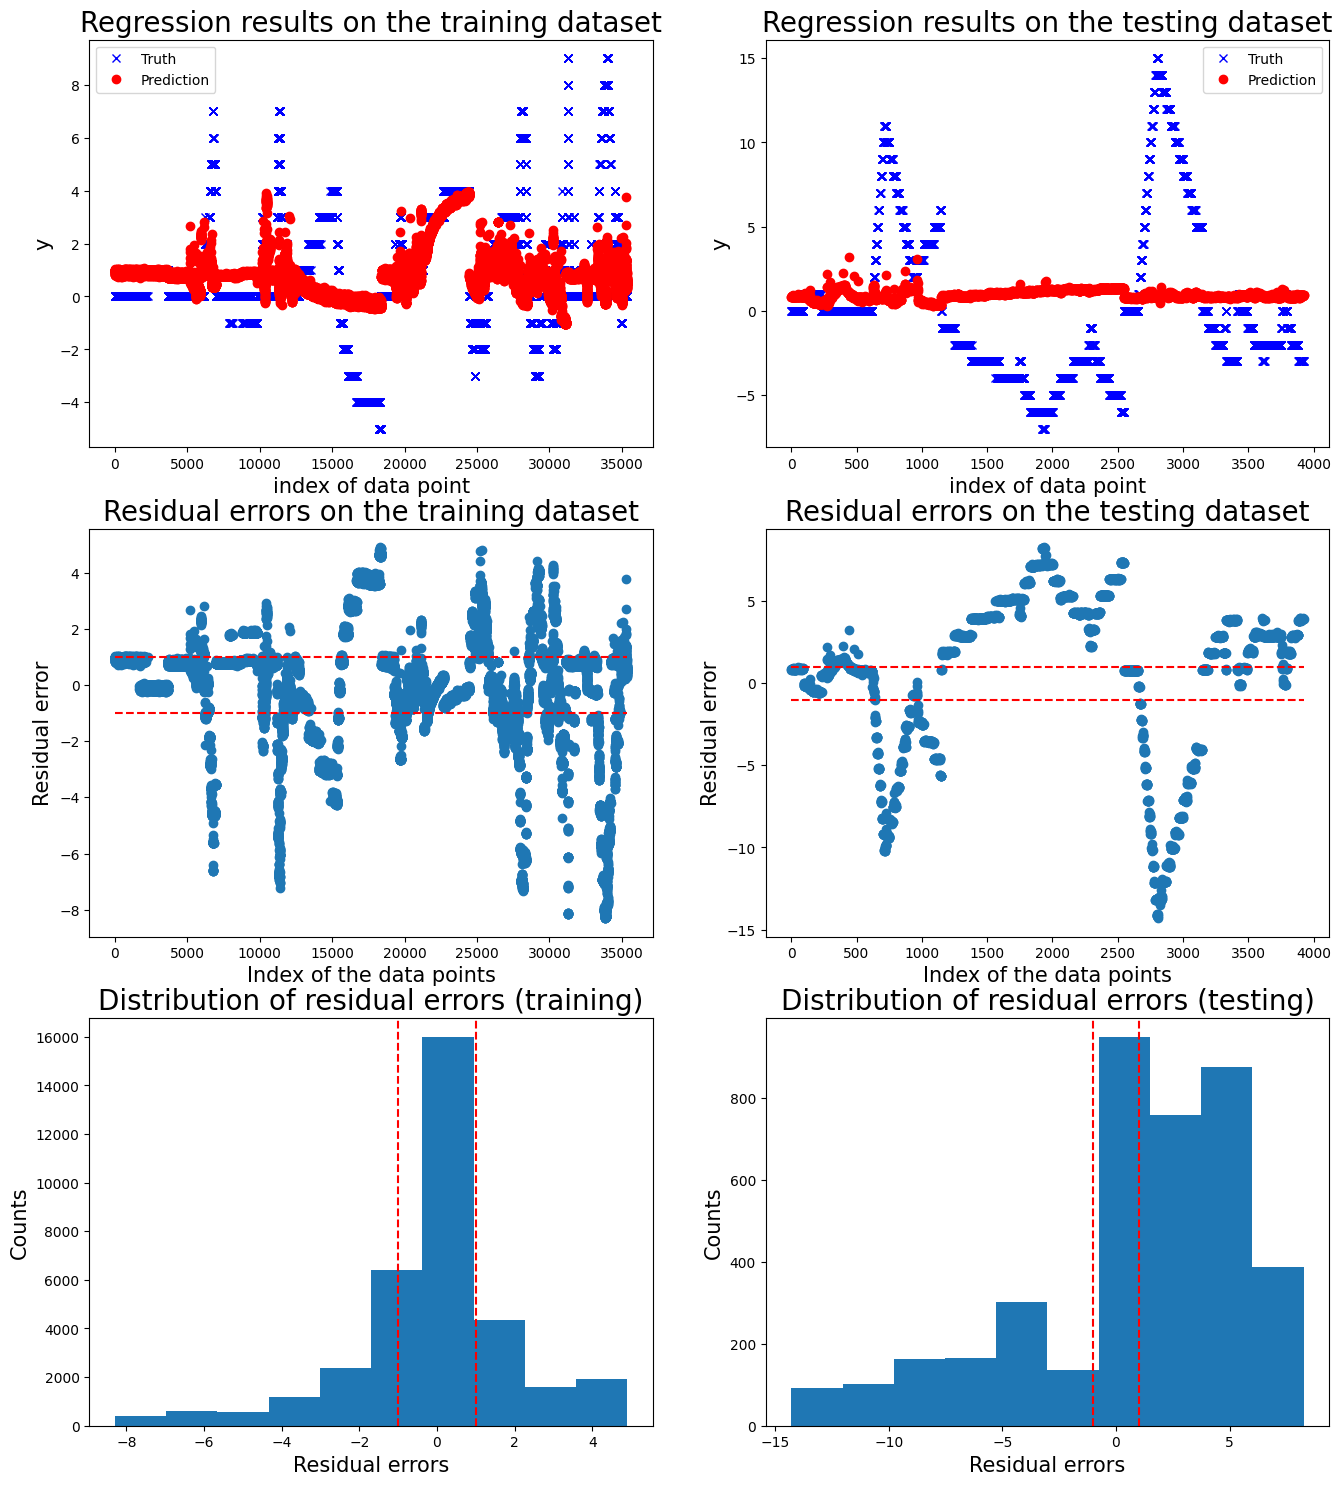

   Max error      RMSE  Exceed boundary rate
0   6.465892  1.210292              0.169864
1  10.918259  3.912235              0.658724
2   8.714872  3.434793              0.334753
3   3.172870  0.879349              0.263736
4  14.296532  4.872452              0.789501


Mean performance metric and standard error:
Max error: 8.7137 +- 4.2362
RMSE: 2.8618 +- 1.7416
Exceed boundary rate: 0.4433 +- 0.2670




In [26]:
from utility import run_cv_one_motor

feature_list_all = [ 'data_motor_1_position','data_motor_2_voltage','data_motor_3_position','data_motor_3_temperature','data_motor_4_temperature','data_motor_6_temperature']

threshold = 1
window_size = 1
sample_step = 1

df_perf = run_cv_one_motor(motor_idx=6, df_data=df_data, mdl=mdl_linear_regreession, 
            feature_list=feature_list_all, n_fold=5, 
            threshold=threshold, window_size=window_size, sample_step=sample_step, mdl_type='reg')

**Summary of the results - Only using features from the current moment**

Please add a table in the end, summarying the results from all the models. Please write a few texts to explain what is the best model you got (including the features and preprocessing you did), its performance, and how could you further improve it.

| Model   | Max error | MRSE | Exceed boundary rate |
|---------|----------|-----------|--------|
| Linear regression |   8.71 |   2.86   |  0.44 | 
|  Ridge regression |   7.6 |   3.8 |  0.83 | 
| Lasso regression |   5.38  |   3.24   |  0.62 | 

### Best Model: Lasso Regression


The best regression model for predicting the normal behaviors of motor 6 is the Linear Regression model. 

#### Features and Preprocessing

- We have made a feature selection based on the correlation matrix of WP1. 
- We smoothed the data to reduce noise and fluctuations.


#### Potential Improvements

1. **Hyperparameter Tuning**:
   - Conduct a more exhaustive search for the optimal value of the regularization parameter (alpha) using techniques like Grid Search or Random Search with cross-validation.

2. **Feature Engineering**:
   - Create new features based on domain knowledge, such as interaction terms or polynomial features, to capture more complex relationships.



3. **Additional Data**:
   - Collect more data if possible to improve the model's learning and generalization capabilities.
   - Include additional relevant features that may impact the motor's behavior.

By implementing these improvements, we can enhance the performance of the Lasso Regression model, making it even more accurate and reliable for predicting the normal behaviors of motor 6.

## Sub-task 2: Include the features in the past

Now, let's consider using the sliding window approach to include the past in the regression model as well. Please have a look at the demo notebook, run your experiment, and report the best models you could have if you apply the sliding window approach.

In [10]:
from utility import run_cv_one_motor


def run_all_motors(df_data, mdl, feature_list, n_fold=5, threshold=3, window_size=1, sample_step=1,
            prediction_lead_time=1, single_run_result=True, mdl_type='reg'):
    all_results = []
    # Loop over all the six motors.
    print(f'Model for predicting temperature of motor 6:')
    # Run cross validation.
    df_perf = run_cv_one_motor(motor_idx=6, df_data=df_data, mdl=mdl, feature_list=feature_list,
            n_fold=n_fold, threshold=threshold, window_size=window_size, sample_step=sample_step,
        prediction_lead_time=prediction_lead_time, single_run_result=single_run_result, mdl_type=mdl_type)
    all_results.append(df_perf)

    return all_results

In [32]:
from utility import run_cv_one_motor


threshold = 1
window_size = 5
sample_step = 1
prediction_lead_time = 1 # We add the temperature measurement up to 1 point before the current time.

all_results = run_all_motors(df_data=df_data, mdl=mdl_linear_regreession, feature_list=feature_list_all, 
            threshold=threshold, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, single_run_result=False)

Model for predicting temperature of motor 6:
Model for motor 6:


c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.

   Max error      RMSE  Exceed boundary rate
0   1.063415  0.182742              0.008304
1   1.985538  0.129814              0.005398
2   1.324690  0.193262              0.011422
3   1.022594  0.123256              0.005618
4   3.000089  0.256674              0.023797


Mean performance metric and standard error:
Max error: 1.6793 +- 0.8329
RMSE: 0.1771 +- 0.0542
Exceed boundary rate: 0.0109 +- 0.0076




c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Summary of the results - Sliding window**

Please add a table in the end, summarying the results from all the models. Please write a few texts to explain what is the best model you got (including the features and preprocessing you did), its performance, and how could you further improve it.

| Model   (also report parameters like window_size, sample_step, prediction_lead_time, etc.) | Max error | MRSE | Exceed boundary rate |
|---------|----------|-----------|--------|
| Linear regression (5,1,1) |   1.64  |   0.14   | 0.0066 | 
| Ridge regression |   1.65  |   0.14   | 0.0055 | 
| Lasso regression |   3.59  |   1.03   | 0.25 | 


Best model: Linear regression

# Task 2 Fault detection based on regression model

In this exercise, we use the dataset that contains the failure of motor 6 to test the fault detection model based on the regression model trained before. 

[This notebook](demo_FaultDetectReg.ipynb) presents a demonstration of how to use the provided supporting function to develop fault detection model based on the regression model. Please have a look at this notebook, and try to improve the performance of the baseline model.

Model for motor 6:


100%|██████████| 1/1 [00:10<00:00, 10.14s/it]



 New run:

testing performance, max error is: 2.6981462157149356
testing performance, mean root square error is: 0.5500023880130954
testing performance, residual error > 1.4952410223515333: 6.036429324100557%

 New run:

testing performance, accuracy is: 0.9637212102965528
testing performance, precision is: 0.9457547169811321
testing performance, recall: 0.6478190630048465
testing performance, F1: 0.7689357622243528




c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


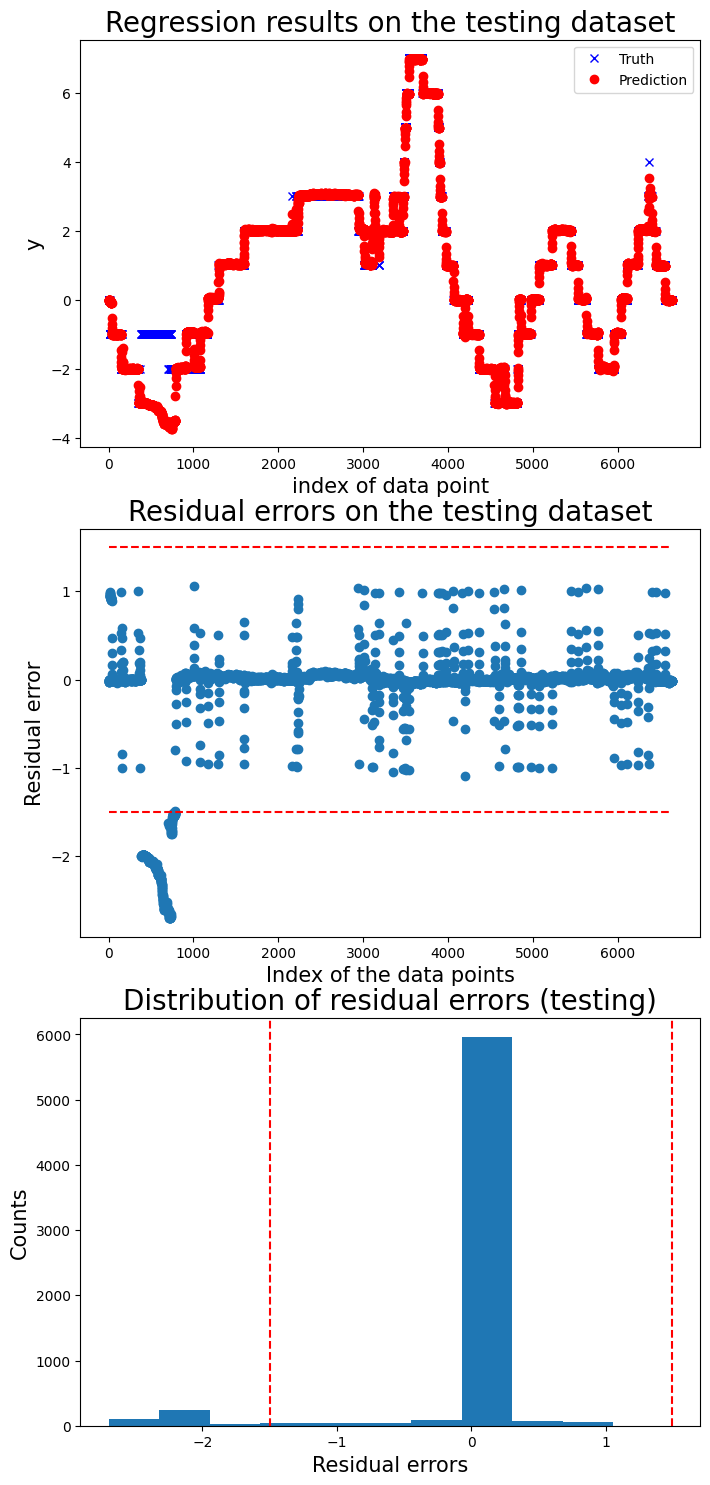

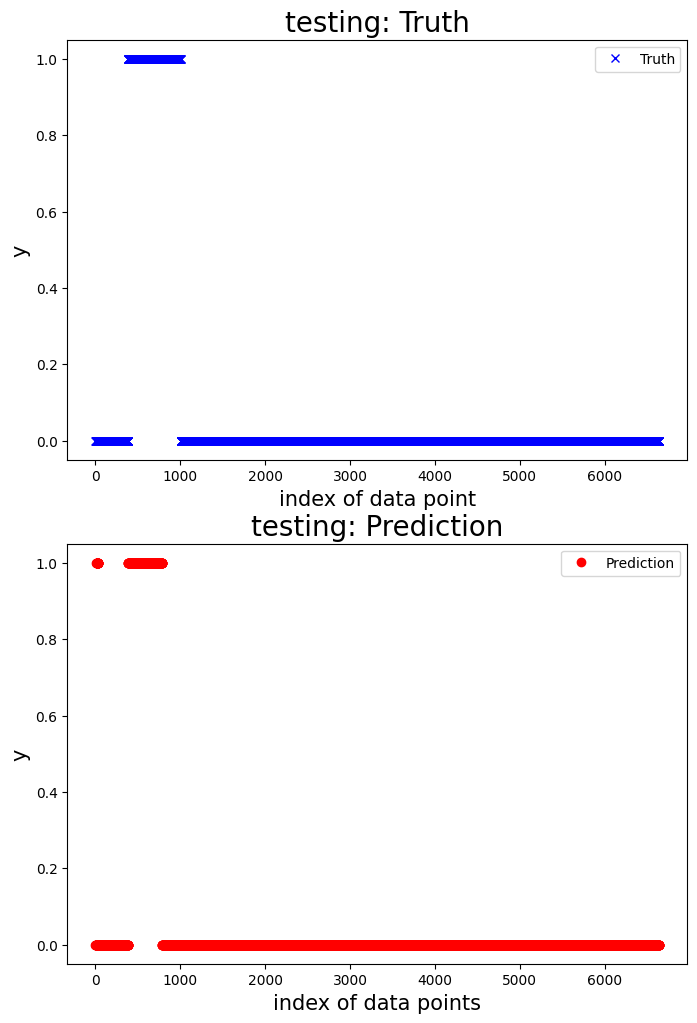

100%|██████████| 1/1 [00:00<00:00,  3.64it/s]



 New run:

testing performance, max error is: 3.9053297908316127
testing performance, mean root square error is: 1.5449701462054302
testing performance, residual error > 0.9: 42.792792792792795%

 New run:

testing performance, accuracy is: 0.8693693693693694
testing performance, precision is: 0.7789473684210526
testing performance, recall: 0.9024390243902439
testing performance, F1: 0.8361581920903954




c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


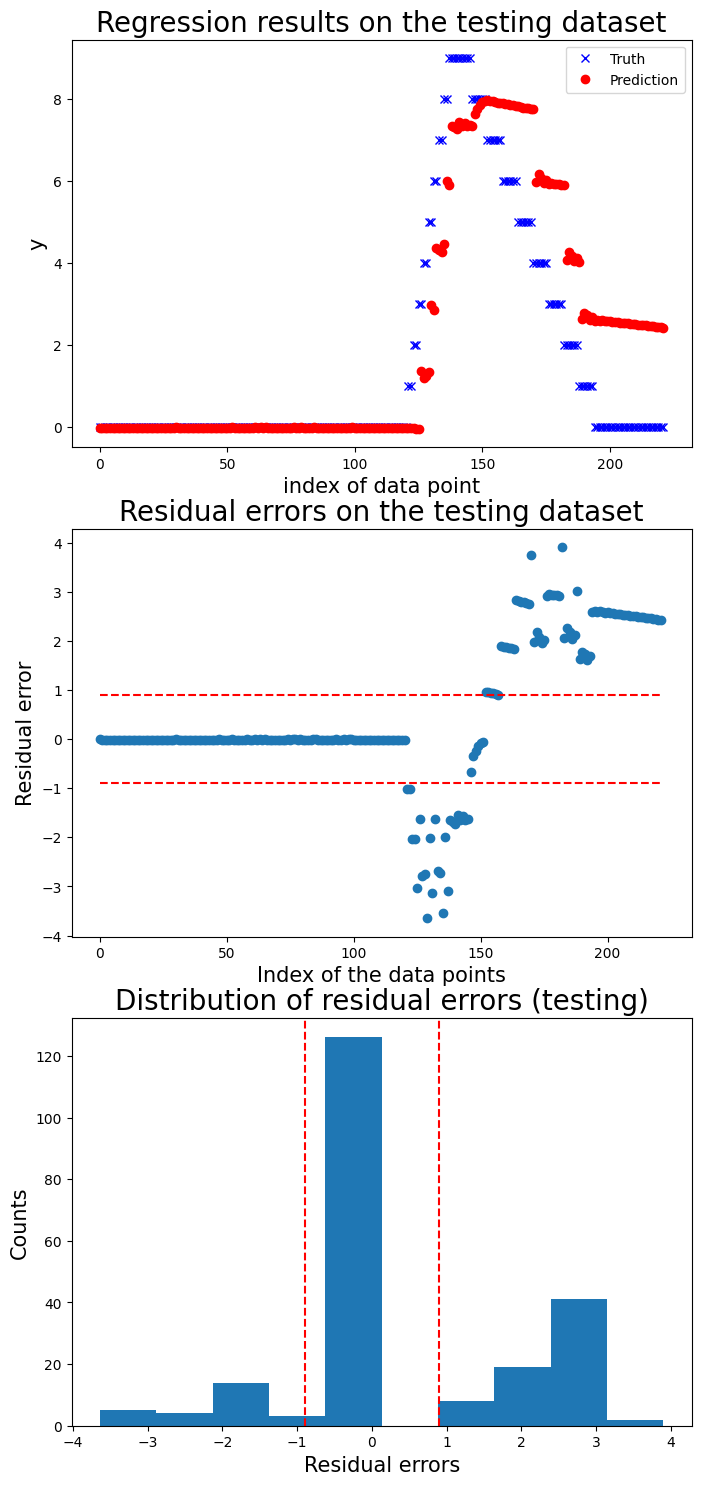

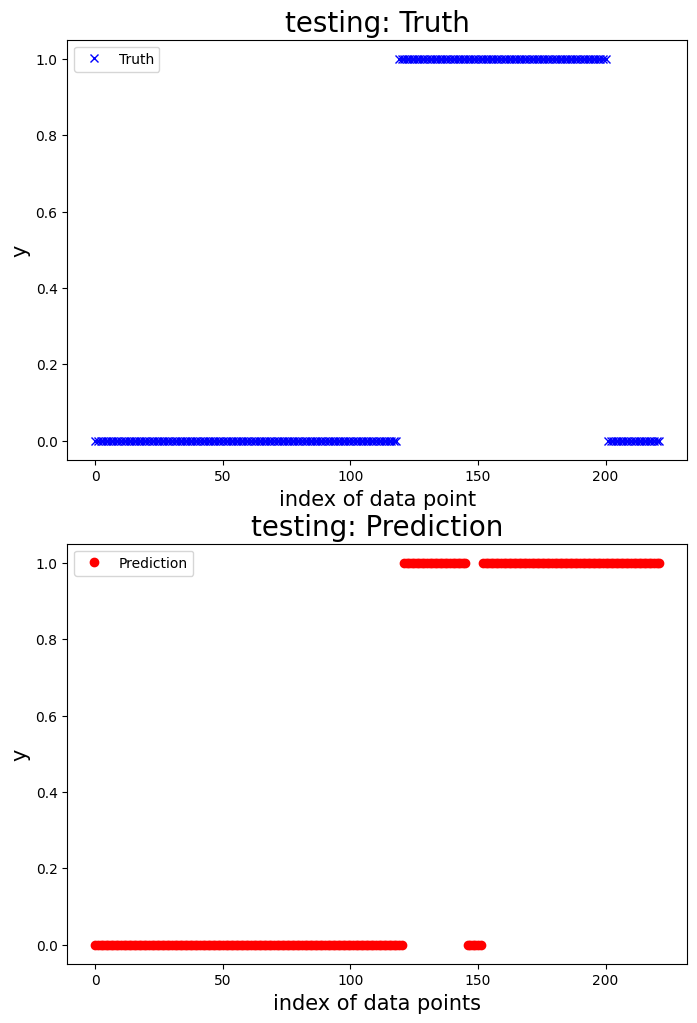

100%|██████████| 1/1 [00:00<00:00,  1.52it/s]



 New run:

testing performance, max error is: 3.0323285984053547
testing performance, mean root square error is: 0.5470881791963881
testing performance, residual error > 0.9: 19.419237749546276%

 New run:

testing performance, accuracy is: 0.8838475499092558
testing performance, precision is: 0.8037383177570093
testing performance, recall: 0.6666666666666666
testing performance, F1: 0.7288135593220338




c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


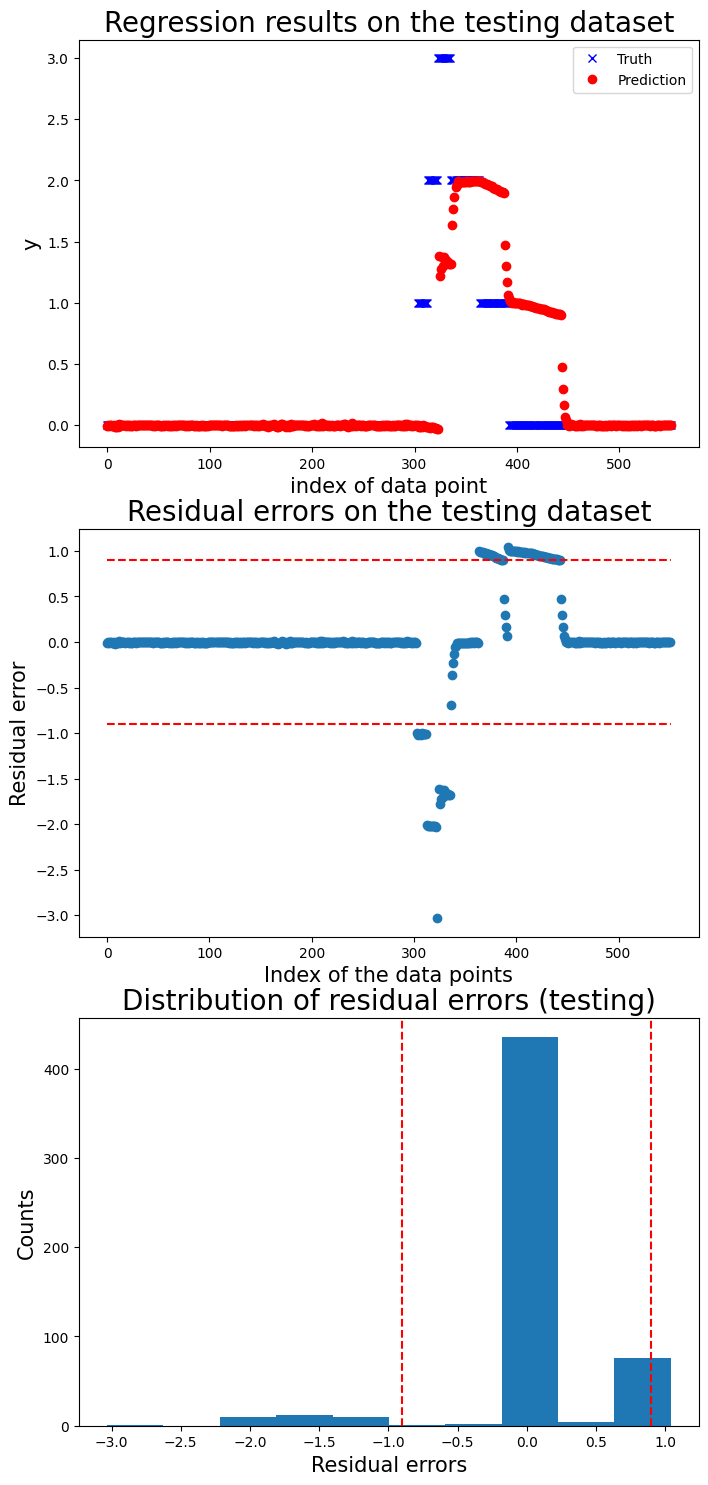

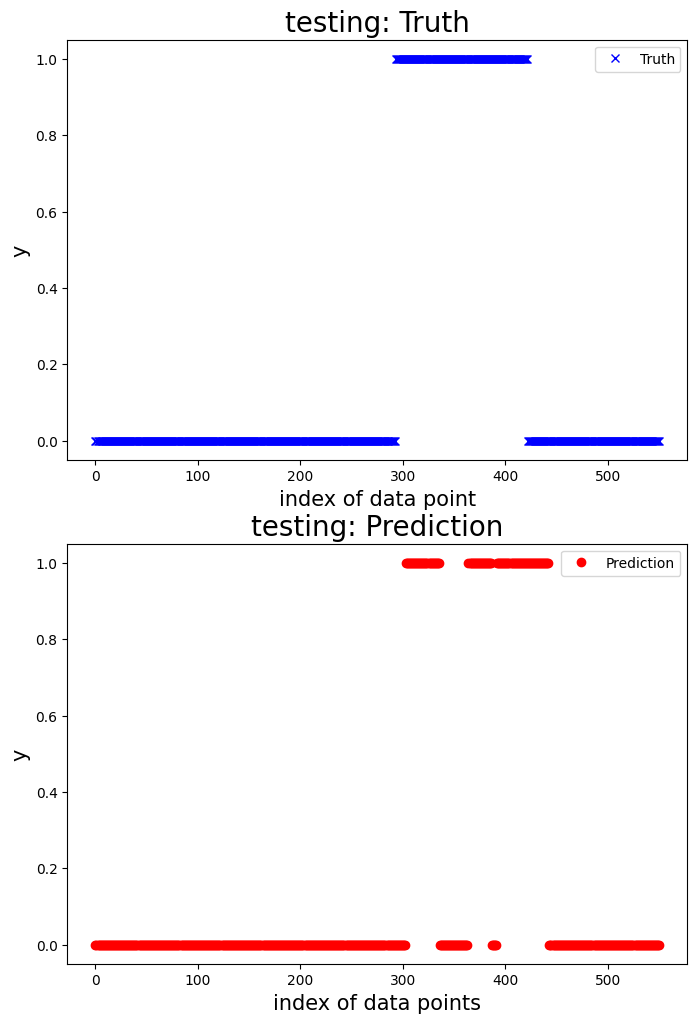

100%|██████████| 1/1 [00:01<00:00,  1.42s/it]



 New run:

testing performance, max error is: 2.0392246276932644
testing performance, mean root square error is: 0.24123215366432468
testing performance, residual error > 0.9: 3.3816425120772946%

 New run:

testing performance, accuracy is: 0.9729468599033816
testing performance, precision is: 1.0
testing performance, recall: 0.5555555555555556
testing performance, F1: 0.7142857142857143




c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


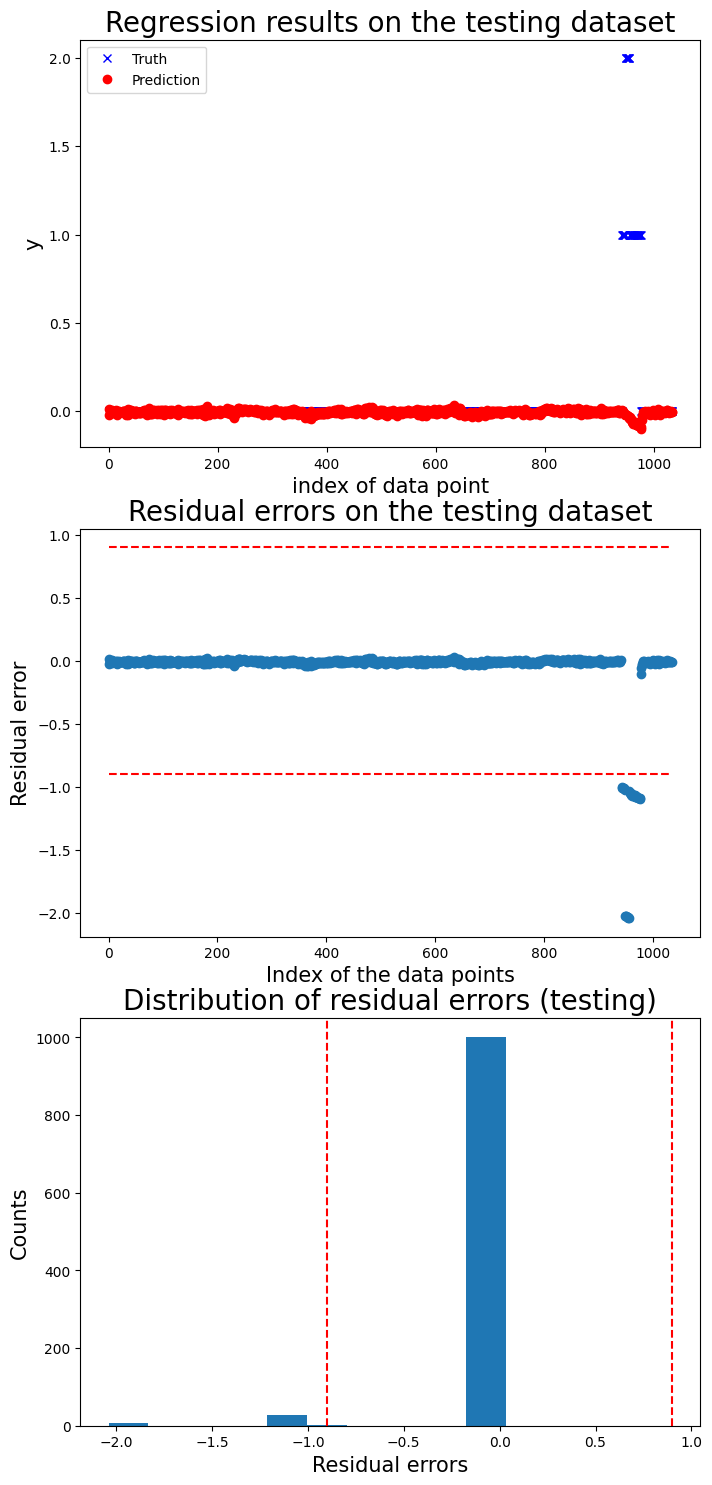

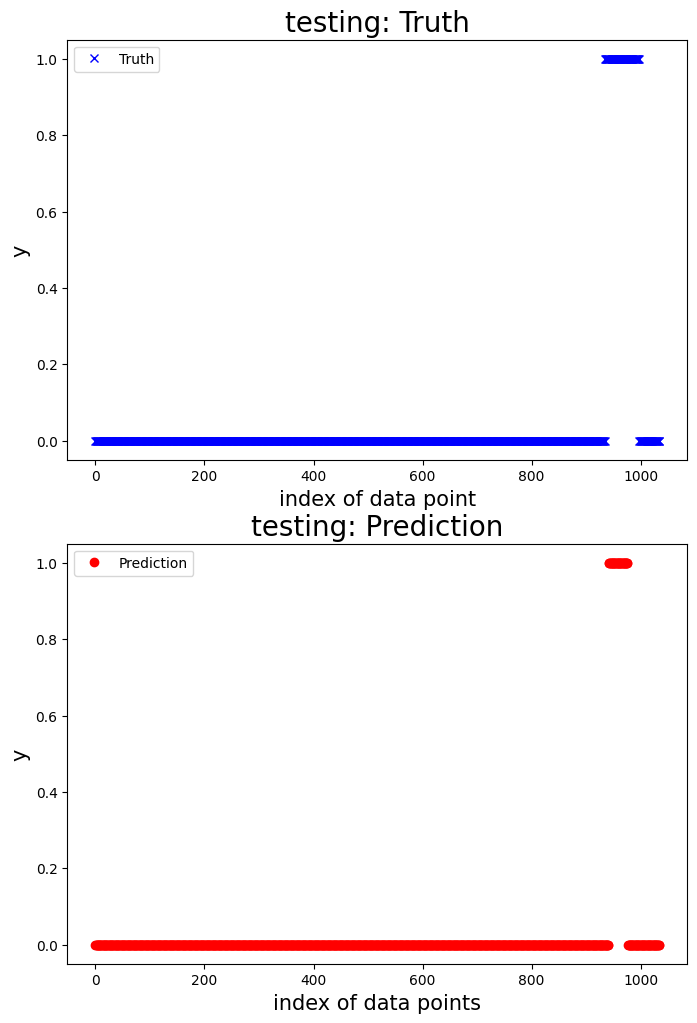

100%|██████████| 1/1 [00:01<00:00,  1.53s/it]



 New run:

testing performance, max error is: 3.964721673370618
testing performance, mean root square error is: 1.2247309840340275
testing performance, residual error > 0.9: 43.859649122807014%

 New run:

testing performance, accuracy is: 0.8061403508771929
testing performance, precision is: 0.626
testing performance, recall: 0.9020172910662824
testing performance, F1: 0.7390791027154664




c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


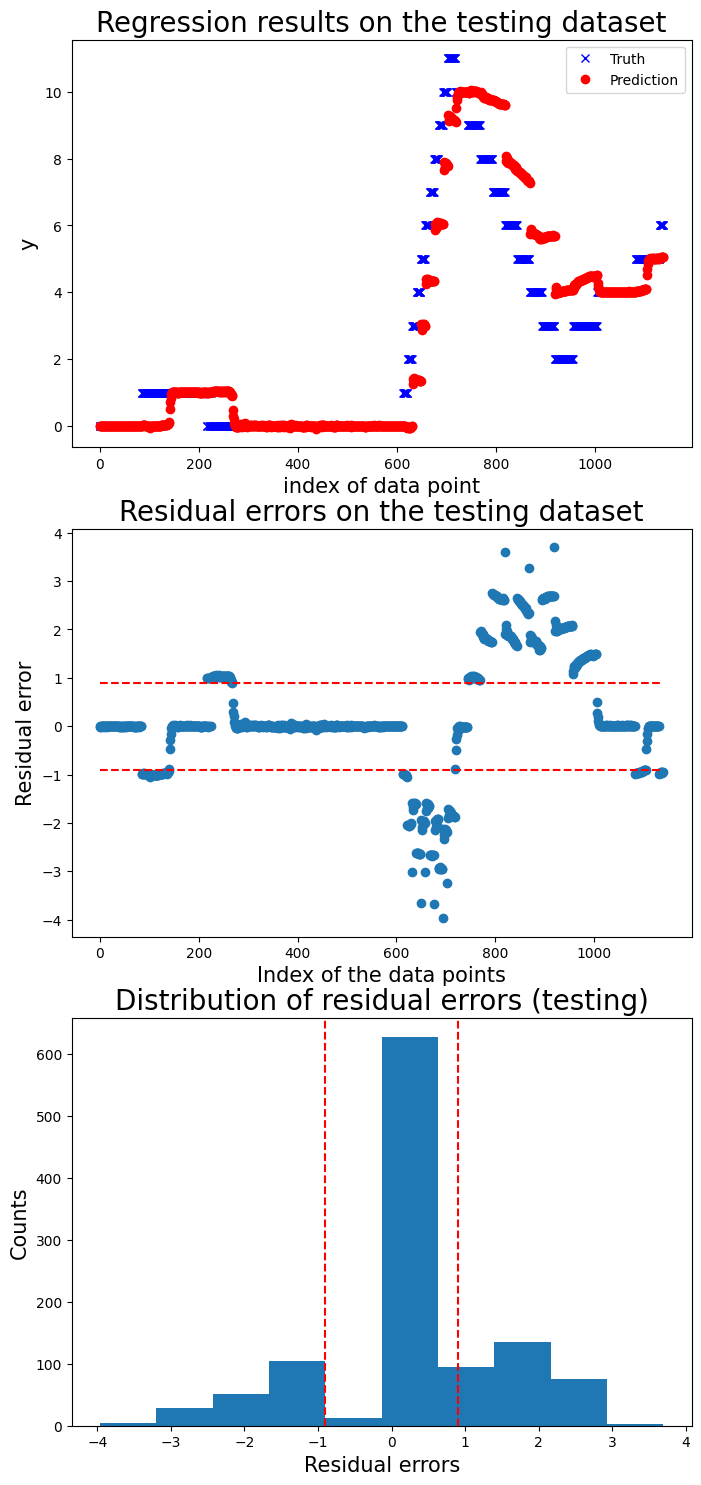

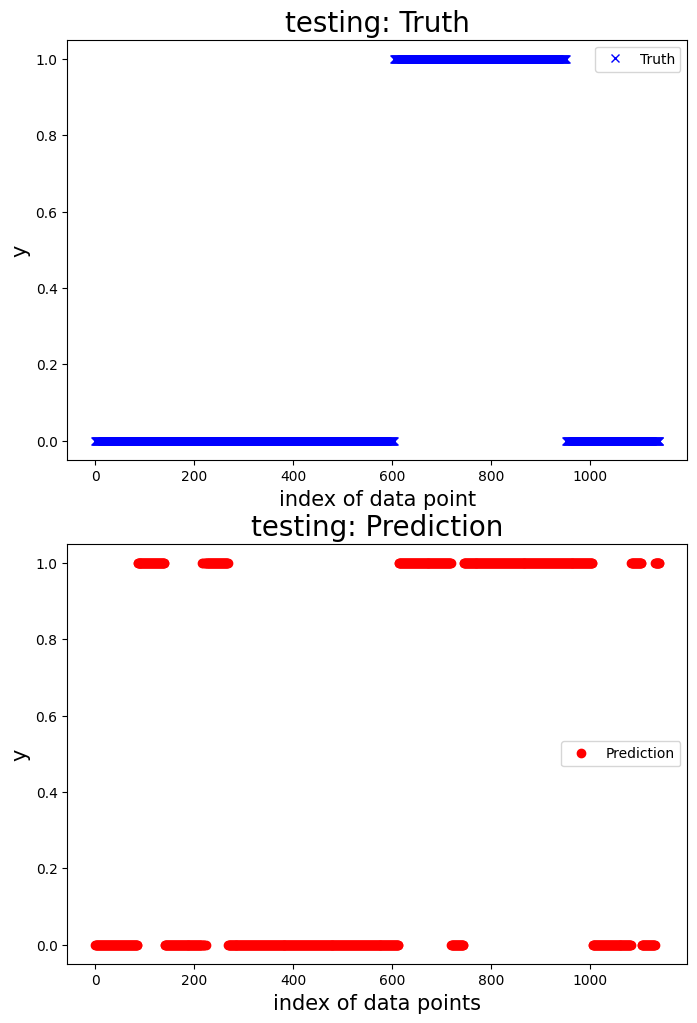

100%|██████████| 1/1 [00:00<00:00,  1.30it/s]



 New run:

testing performance, max error is: 3.9886955905044665
testing performance, mean root square error is: 1.8337589561879617
testing performance, residual error > 0.9: 67.45762711864407%

 New run:

testing performance, accuracy is: 0.7966101694915254
testing performance, precision is: 0.9522613065326633
testing performance, recall: 0.7895833333333333
testing performance, F1: 0.8633257403189066




c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


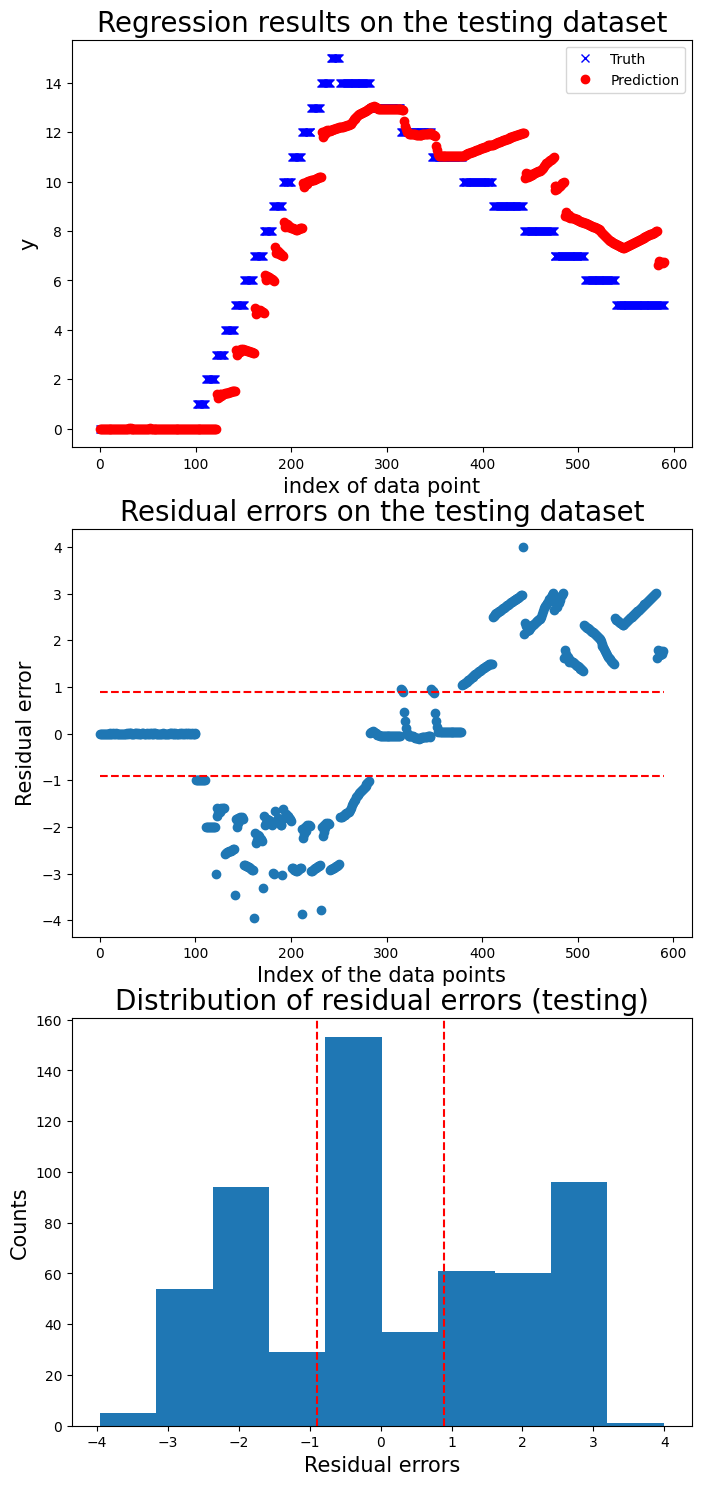

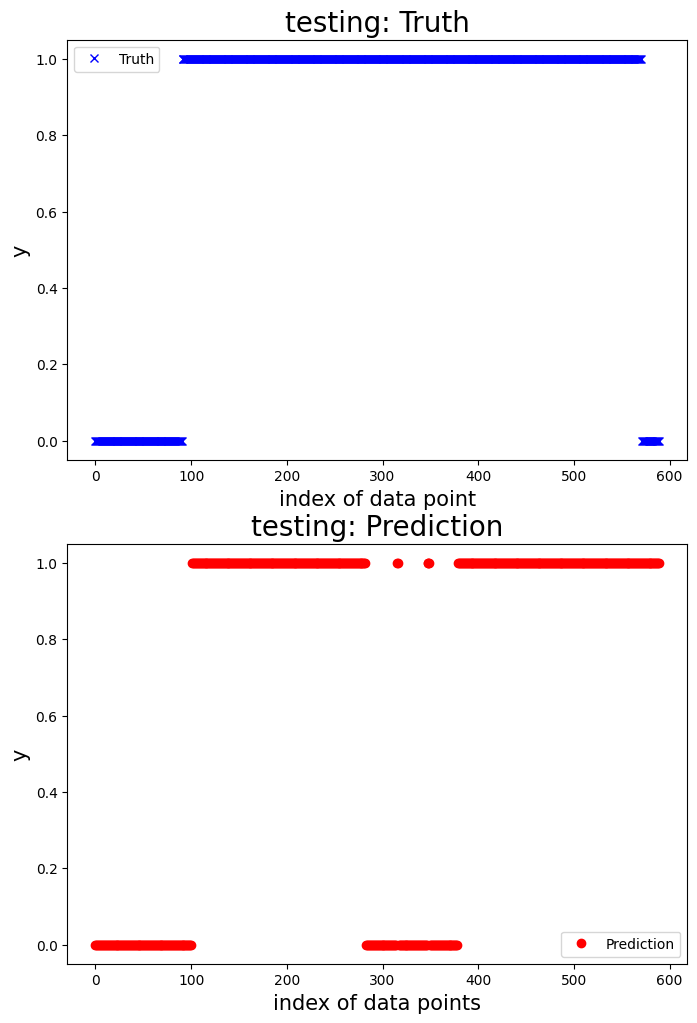

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]



 New run:

testing performance, max error is: 2.9672687761118675
testing performance, mean root square error is: 1.1767111896265503
testing performance, residual error > 1.4018126052786308: 19.140625%

 New run:

testing performance, accuracy is: 0.5234375
testing performance, precision is: 0.15
testing performance, recall: 0.15566037735849056
testing performance, F1: 0.1527777777777778




c:\Users\weing\Documents\Centrale\Maintenance\Group_5\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


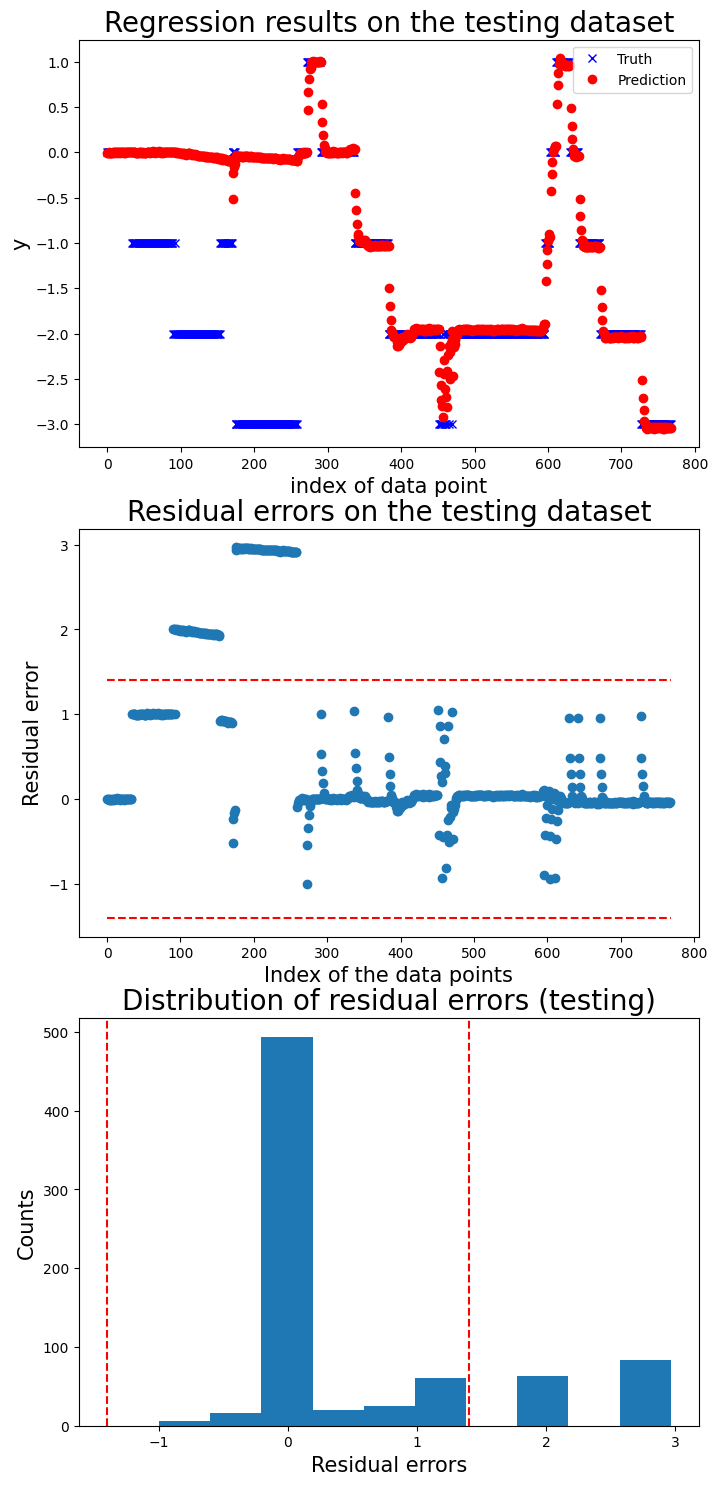

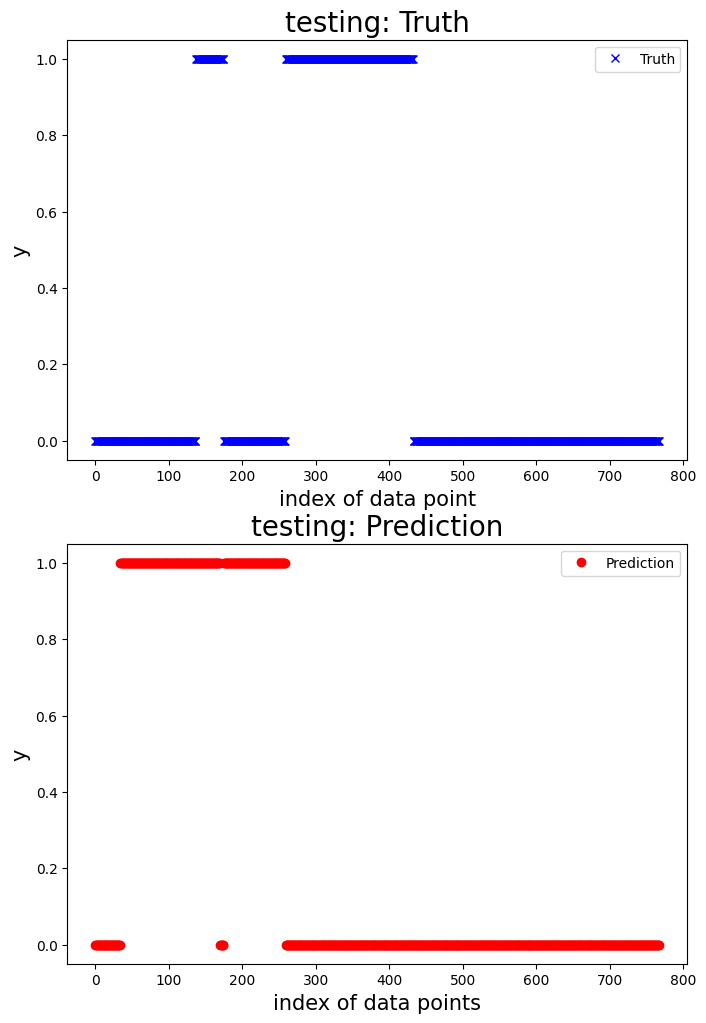

   Accuracy  Precision    Recall  F1 score
0  0.963721   0.945755  0.647819  0.768936
1  0.869369   0.778947  0.902439  0.836158
2  0.883848   0.803738  0.666667  0.728814
3  0.972947   1.000000  0.555556  0.714286
4  0.806140   0.626000  0.902017  0.739079
5  0.796610   0.952261  0.789583  0.863326
6  0.523438   0.150000  0.155660  0.152778


Mean performance metric and standard error:
Accuracy: 0.8309 +- 0.1519
Precision: 0.7510 +- 0.2946
Recall: 0.6600 +- 0.2581
F1 score: 0.6862 +- 0.2417




In [29]:
# Your code here:

# Test the class FaultDetectReg

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from utility import read_all_test_data_from_path, extract_selected_feature, prepare_sliding_window, FaultDetectReg


def remove_outliers(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()
    df['temperature'] = df['temperature'] - df['temperature'].iloc[0]

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()
    df['voltage'] = df['voltage'] - df['voltage'].iloc[0]

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()
    df['position'] = df['position'] - df['position'].iloc[0]


# Read data.
base_dictionary = 'C:/Users/weing/Documents/Centrale/Maintenance/Group_5/projects/maintenance_industry_4_2024/dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, remove_outliers, is_plot=False)

# Pre-train the model.
# Get all the normal data.
normal_test_id = ['20240105_164214', 
    '20240105_165300', 
    '20240105_165972', 
    '20240320_152031', 
    '20240320_153841', 
    '20240320_155664', 
    '20240321_122650', 
    '20240325_135213',
    '20240325_152902', 
    '20240426_141190', 
    '20240426_141532', 
    '20240426_141602', 
    '20240426_141726', 
    '20240426_141938', 
    '20240426_141980', 
    '20240503_164435']

df_tr = df_data[df_data['test_condition'].isin(normal_test_id)]

feature_list_all = ['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

# feature_list_all = ['time', 'data_motor_1_position', 
#                 'data_motor_2_position', 
#                 'data_motor_3_position', 
#                 'data_motor_4_position', 
#                 'data_motor_5_position', 
#                 'data_motor_6_position', 'data_motor_6_temperature']

# Prepare feature and response of the training dataset.
x_tr_org, y_temp_tr_org = extract_selected_feature(df_data=df_tr, feature_list=feature_list_all, motor_idx=6, mdl_type='reg')

# Enrich the features based on the sliding window.
window_size = 10
sample_step = 1
prediction_lead_time = 1 
threshold = .9
abnormal_limit = 3

x_tr, y_temp_tr = prepare_sliding_window(df_x=x_tr_org, y=y_temp_tr_org, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='reg')

# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', LinearRegression())    # Step 2: Linear Regression
]

# Create the pipeline
mdl_linear_regreession = Pipeline(steps)
# Fit the model
mdl = mdl_linear_regreession.fit(x_tr, y_temp_tr)

# Test data.
test_id = [
    '20240325_155003',
    '20240425_093699',
    '20240425_094425',
    '20240426_140055',
    '20240503_163963',
    '20240503_164675',
    '20240503_165189'
]
df_test = df_data[df_data['test_condition'].isin(test_id)]

# Define the fault detector.
detector_reg = FaultDetectReg(reg_mdl=mdl, threshold=threshold, abnormal_limit=abnormal_limit, window_size=window_size, sample_step=sample_step, pred_lead_time=prediction_lead_time)

# # Test
# _, y_label_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list_all, motor_idx=6, mdl_type='clf')
# x_test_org, y_temp_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list_all, motor_idx=6, mdl_type='reg')

# # Predict the temperature
# detector_reg.threshold = 1
# y_label_pred_tr, y_temp_pred_tr = detector_reg.predict(df_x_test=x_tr_org, y_response_test=y_temp_tr_org)
# y_label_pred_tmp, y_temp_pred_tmp = detector_reg.predict(df_x_test=x_test_org, y_response_test=y_temp_test_org)

# # Get the true values.
# _, y_label_test = prepare_sliding_window(df_x=x_test_org, y=y_label_test_org, sequence_name_list=test_id, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='clf')
# _, y_temp_test_seq = prepare_sliding_window(df_x=x_test_org, y=y_temp_test_org, sequence_name_list=test_id, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='reg')


# show_reg_result(y_tr=y_temp_tr, y_test=y_temp_test_seq, y_pred_tr=y_temp_pred_tr, y_pred=y_temp_pred_tmp, threshold=detector_reg.threshold)
# show_clf_result(y_tr=np.zeros(len(y_label_pred_tr)), y_test=y_label_test, y_pred_tr=y_label_pred_tr, y_pred=y_label_pred_tmp)

# # Run cross validation
n_fold = 7
_, y_label_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list_all, motor_idx=6, mdl_type='clf')
x_test_org, y_temp_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list_all, motor_idx=6, mdl_type='reg')

motor_idx = 6
print(f'Model for motor {motor_idx}:')
# Run cross validation.
df_perf = detector_reg.run_cross_val(df_x=x_test_org, y_label=y_label_test_org, y_response=y_temp_test_org, 
                                        n_fold=n_fold)
print(df_perf)
print('\n')
# Print the mean performance and standard error.
print('Mean performance metric and standard error:')
for name, metric, error in zip(df_perf.columns, df_perf.mean(), df_perf.std()):
    print(f'{name}: {metric:.4f} +- {error:.4f}') 
print('\n')

## Summary of the results

Please add a table in the end, summarying the results from all the models (including the unsupervised learning models). Please write a few texts to explain what is the best model you got (including key parameters like threshold, window_size, sample_step, prediction_lead_time, etc), its performance, and how could you further improve it.

| Model   | Accuracy | Precision | Recall | F1   |
|---------|----------|-----------|--------|------|
| Linear regression |   83.1%  |   75.1%   | 66.0% | 68.6%|
| Ridge regression |   83.1%  |   75.1%   | 66.0% | 68.6%|
| Lasso regression |   72.6%  |  70.4%   |  68.8% | 55.8%|


The best model is again the linear regression.

*Further Improvements*

*-Feature Engineering:* Introducing new features or transforming existing ones could help capture more relevant patterns in the data, potentially improving model performance.

*-Hyperparameter Tuning:* Using techniques like Grid Search or Random Search to fine-tune hyperparameters beyond the initial values.


*-Data Augmentation:* Generating synthetic data points could help the model learn better from a more varied dataset.

*-Advanced Algorithms:* Exploring more sophisticated algorithms such as Gradient Boosting Machines (GBMs) or Neural Networks for potentially better performance.